In [113]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import numpy as np
import math
import datetime
from textblob import TextBlob
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (9, 6)
pd.set_option('display.max_columns', 100)
pd.options.display.max_rows = 999

### Data extraction

In [2]:
# Read review file with 10M rows
review_df = pd.read_json('item_dedup_reviews3.json', lines=True)
#review_df.to_pickle('review_df_1M.pkl')

In [3]:
# Let's visualize the review file
review_df.head()
print (review_df.shape)

(10000000, 9)


In [4]:
# Convert unixReviewtime to datetime
review_df['timestamp'] = pd.to_datetime(review_df['unixReviewTime'],unit='s')
review_df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,timestamp
0,B00691AF68,"[0, 0]",3,"I bought this case for the kickstand alone, si...","06 26, 2012",A2OTZJKZBLTRAQ,Randy,"4 stars for sturdiness, NO STARS FOR THE KICKS...",1340668800,2012-06-26
1,B004XCLYSS,"[0, 0]",5,Vintage style face gives an antique feel. Ban...,"02 9, 2013",A3QVJW34MZU61W,tjnks,Must have,1360368000,2013-02-09
2,0988703009,"[0, 0]",2,What disguises itself as a dystopian novel is ...,"07 10, 2014",A3IO3F5RJOPN6H,A.,Not what I expected,1404950400,2014-07-10
3,0323004318,"[0, 0]",5,Great information that every nursing student s...,"01 15, 2013",A1Z7LRIQXKXQDC,E. Whisenhunt,Great Information,1358208000,2013-01-15
4,B001CFRF7I,"[5, 5]",4,This heater works good. You have to have the ...,"01 23, 2013",A2O962SNGYQEK,BRYAN FISHER,it has it's place,1358899200,2013-01-23


In [5]:
# Function to load json file and read into pandas
def parse(path):
  g = open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    d = {key: d[key] if key in d else '' for key in ['asin', 'categories', 'price', 'related']}
    d['categories'] = d['categories'][0] if d['categories'] != '' else ''
    d['bought_together'] = d['related']['bought_together'] if d['related'] != '' and 'bought_together' in d['related'] else ''
    del d['related']
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [6]:
# read metadata file and pickle to store
meta_df = getDF('metadata.json')
meta_df.head()
meta_df.to_pickle('meta_df1.pkl')

KeyboardInterrupt: 

In [6]:
# read pickle file into pandas dataframe
pickle_in = open("meta_df1.pkl","rb")
meta_df2 = pickle.load(pickle_in)

In [7]:
meta_df2.head(2)

,asin,categories,price,bought_together
0,0001048791,[Books],,
1,0000143561,"[Movies & TV, Movies]",12.99,


In [8]:
# Merge metadata & reviews file
product_df = pd.merge(review_df, meta_df2, on = ['asin'], how = 'left')
product_df.shape

(10000000, 13)

In [9]:
product_df.head(2)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,timestamp,categories,price,bought_together
0,B00691AF68,"[0, 0]",3,"I bought this case for the kickstand alone, si...","06 26, 2012",A2OTZJKZBLTRAQ,Randy,"4 stars for sturdiness, NO STARS FOR THE KICKS...",1340668800,2012-06-26,"[Cell Phones & Accessories, Cases, Basic Cases]",35.99,"[B006JHU3DC, B0064R6VWO]"
1,B004XCLYSS,"[0, 0]",5,Vintage style face gives an antique feel. Ban...,"02 9, 2013",A3QVJW34MZU61W,tjnks,Must have,1360368000,2013-02-09,"[Clothing, Shoes & Jewelry, Women]",80.00,


In [10]:
# Drop duplicate rows with reviews of same product by same user
product_df.drop_duplicates(subset=['asin', 'reviewerID'], keep='first', inplace=True)

In [11]:
product_df.shape

(10000000, 13)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


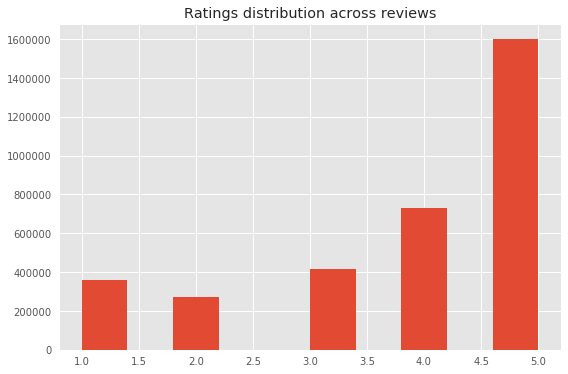

In [105]:
# Let's plot the ratings distrbution
overall_plot = product_df.loc[:, ['overall', 'asin']].drop_duplicates().overall.hist()
overall_plot.set_title("Ratings distribution across reviews")
price_plot.set_xlabel("Overall")
price_plot.set_ylabel("Number of reviews");

Looks like there are no duplicate reviews.

------------------

### 1. Connection between reviews of items bought together

Thee are 2 questions to answer here:
    - How does helpfulness vary between products bought together?
    - How do rating vary between products bought together?

In [12]:
# Get list of unique productids
bt_prods = product_df.loc[product_df.bought_together != '', 'asin'].unique()
len(bt_prods)

1473125

In [17]:
product_df.sample(2)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,timestamp,categories,price,bought_together
3821694,B005W7JCRS,"[0, 0]",5,i finally just got around to buying thi...,"03 10, 2012",A2A6UV0Y2SPYMM,Edward J. mccarthy Jr.,there best in years,1331337600,2012-03-10,"[CDs & Vinyl, Classic Rock]",31.41,[B00HEVGK66]
8508954,B005W2BWDA,"[0, 0]",5,I bought this set of DVDs because I have just ...,"03 16, 2012",AH6OF6FSXUC92,"Budd Young ""Lonewolf""",In the Beginning,1331856000,2012-03-16,"[Movies & TV, TV]",59.99,"[B007K7IB0C, B005QW98JQ]"


Let's take a sample of 1000 rows from meta_df3 as the entire dataset is too large to perfom manipulation on.

In [18]:
bt_prods_1000 = bt_prods[:10000]
bt_data = meta_df2.loc[meta_df2.asin.isin(bt_prods_1000), ['asin', 'bought_together']]
print(bt_data.shape)
bt_data.sample(2)

(9307, 2)


,asin,bought_together
237835,0387001255,[0791474984]
491688,0714863637,"[1607743973, 0714859036]"


In [19]:
asin_list_all = [y for x in bt_data.bought_together.values for y in x]
asin_list_all = asin_list_all + bt_data.asin.tolist()
asin_list_all = list(set(asin_list_all))

In [21]:
pdf_samp = product_df.loc[product_df.asin.isin(asin_list_all), :].copy()
pdf_samp['helpful_votes'] = pdf_samp.helpful.apply(lambda x: x[0])
pdf_samp['overall_votes'] = pdf_samp.helpful.apply(lambda x: x[1])
pdf_samp['percent_helpful'] = pdf_samp['helpful_votes']*100.0/pdf_samp['overall_votes']
pdf_samp = pdf_samp.groupby('asin')['percent_helpful', 'overall'].mean()
pdf_samp.sample(2)

,percent_helpful,overall
asin,,
B0040UPTA2,100.00,5.00
0606235434,52.80,4.64


In [22]:
bt_data.sample(2)

,asin,bought_together
5519515,B004U901PQ,"[B007XUCPLC, B007NXPWSC, B00A8E82IU, B0098X5D66]"
7531467,B009VTH2JI,"[B000XR4OC0, B00B81RVE8, B006LC4S2W]"


In [23]:
# Calculate average helpfulness & ratings of bought together products
help_list=[]
rating_list=[]
for bt_list in bt_data.bought_together.tolist():
    bt_list = [x for x in bt_list if x in pdf_samp.index]
    tmp = pdf_samp.loc[bt_list, :]
    avg_helpfulness = tmp.percent_helpful.mean()
    avg_rating = tmp.overall.mean()
    help_list.append(avg_helpfulness)
    rating_list.append(avg_rating)

In [24]:
bt_data['bought_together_helpfulness'] = pd.Series(help_list, index=bt_data.index)
bt_data['bought_together_rating'] = pd.Series(rating_list, index=bt_data.index)

In [25]:
#Calculate helpfulness and rating of original products
bt_data['this_helpfulness'] = pd.Series([pdf_samp.loc[x, 'percent_helpful']
                                         for x in bt_data.asin.tolist()], index=bt_data.index)
bt_data['this_rating'] = pd.Series([pdf_samp.loc[x, 'overall']
                                    for x in bt_data.asin.tolist()], index=bt_data.index)

In [26]:
bt_data.sample(2)

,asin,bought_together,bought_together_helpfulness,bought_together_rating,this_helpfulness,this_rating
4391542,B002VBE6N8,"[B002VBJUY8, B002VBE6S8]",50.00,3.75,70.30,3.27
7281752,B0092HP3EA,[B00IWA1MNE],28.46,4.12,51.09,2.57


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


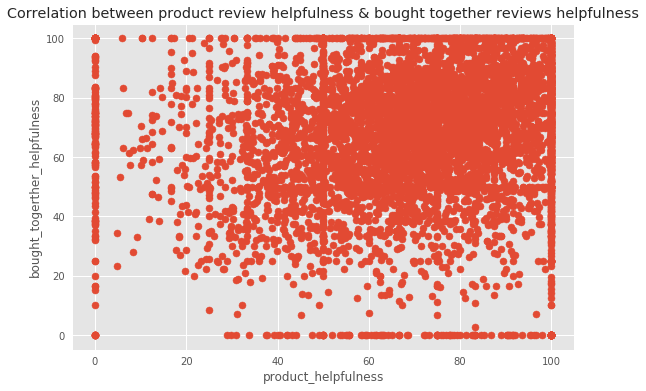

In [114]:
# Plot helpfulness of original product and bought together product
bt_data.dropna(inplace=True)
plt.scatter(bt_data.this_helpfulness, bt_data.bought_together_helpfulness)
plt.title("Correlation between product review helpfulness & bought together reviews helpfulness")
plt.xlabel("product_helpfulness")
plt.ylabel("bought_togerther_helpfulness")

In [28]:
print (bt_data['this_helpfulness'].corr(bt_data['bought_together_helpfulness']))

0.169151229407


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


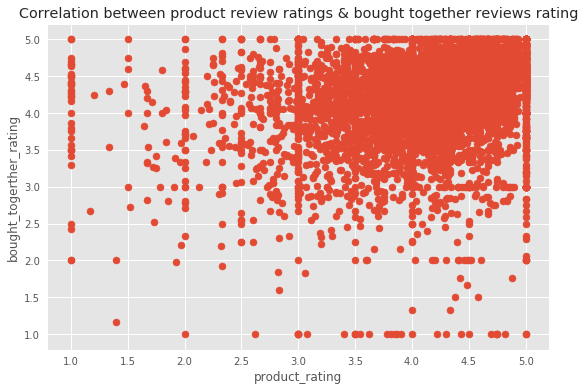

In [29]:
# Plot ratings of original product and bought together product
plt.scatter(bt_data.this_rating, bt_data.bought_together_rating)
plt.title("Correlation between product review ratings & bought together reviews rating")
plt.xlabel("product_rating")
plt.ylabel("bought_togerther_rating")

In [116]:
print (bt_data['this_rating'].corr(bt_data['bought_together_rating']))

0.280694303


----------

### 2. What is the relation between the reviews and the helpfulness?

In [31]:
review_df.helpful.sample(5)

2188091     [0, 0]
6324902    [8, 11]
8425758     [0, 0]
9476139     [3, 9]
4728890     [1, 1]
Name: helpful, dtype: object

The ‘helpful’ column contains values that look like this ‘[12, 49]’. The first value represents the number of helpful votes, the second represents overall votes. This data is useful to us, but not in this form, so let’s create some additional columns!

In [32]:
#Extract helpfulness information
review_df['helpful_votes'] = review_df.helpful.apply(lambda x: x[0])
review_df['overall_votes'] = review_df.helpful.apply(lambda x: x[1])
review_df['percent_helpful'] = review_df['helpful_votes']*100.0/review_df['overall_votes']

In [33]:
review_df.head(2)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,timestamp,helpful_votes,overall_votes,percent_helpful
0,B00691AF68,"[0, 0]",3,"I bought this case for the kickstand alone, si...","06 26, 2012",A2OTZJKZBLTRAQ,Randy,"4 stars for sturdiness, NO STARS FOR THE KICKS...",1340668800,2012-06-26,0,0,nan
1,B004XCLYSS,"[0, 0]",5,Vintage style face gives an antique feel. Ban...,"02 9, 2013",A3QVJW34MZU61W,tjnks,Must have,1360368000,2013-02-09,0,0,nan


** (i) How many reviews are helpful? **

Among all reviews, almost a third (30%) are not voted on at all. Let's divide the reviews that were voted upon into three categories: Helpful reviews had more than 75% of voters find the review helpful, unhelpful reviews had less than 25% of voters find the review helpful, and an intermediate group of 25-75% helpfulness. This choice of division seemed to not have a larger impact on results; we will henceforth use this terminology to describe the helpfulness of reviews. Among reviews that are voted on, helpful reviews are the most commonas shown in the histogram below.

In [34]:
review_df['helpfulness_category'] = ''
review_df.helpfulness_category.loc[review_df.percent_helpful.isnull()] = 'no_indication'
review_df.helpfulness_category.loc[review_df.percent_helpful == 0] = 'no_indication'
review_df.helpfulness_category.loc[review_df.percent_helpful <= 25]  = 'less_than_25%'
review_df.helpfulness_category.loc[(review_df.percent_helpful > 25) & (review_df.percent_helpful <= 75)]  = '25%_to_75%'
review_df.helpfulness_category.loc[(review_df.percent_helpful > 75)]  = 'greater_than_75%'

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [35]:
review_df['helpfulness_category'].value_counts()

no_indication       5489701
greater_than_75%    2745774
25%_to_75%          1025387
less_than_25%        739138
Name: helpfulness_category, dtype: int64

In [36]:
helpfulness_df = review_df.helpfulness_category.value_counts().reset_index()
helpfulness_df.rename(columns={'index': 'helpfulness'}, inplace=True)
helpfulness_df['percentage_of_reviews'] = helpfulness_df['helpfulness_category']*100.0/helpfulness_df['helpfulness_category'].sum()
helpfulness_df['helpfulness'] = helpfulness_df['helpfulness'].astype(str)

In [37]:
helpfulness_df = helpfulness_df.iloc[[0, 3, 2, 1], :]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


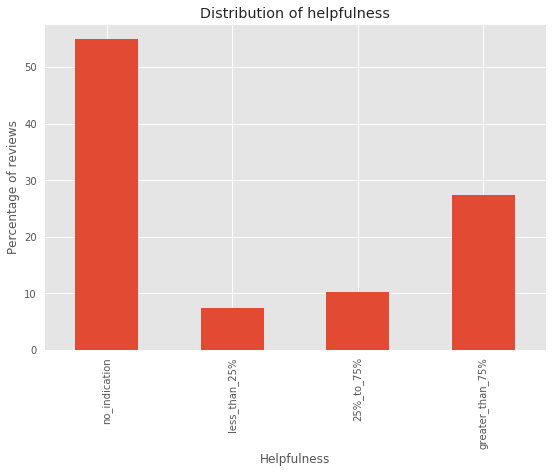

In [38]:
helpfulness_plot = helpfulness_df.plot(x='helpfulness', y='percentage_of_reviews', kind='bar')
helpfulness_plot.set_title("Distribution of helpfulness")
helpfulness_plot.set_xlabel("Helpfulness")
helpfulness_plot.set_ylabel("Percentage of reviews")
helpfulness_plot.legend_.remove()

** (ii) How do ratings affect helpfulness? **

In [39]:
review_df1 = review_df[(review_df['helpfulness_category'] == 'less_than_25%') | \
                       (review_df['helpfulness_category'] == 'greater_than_75%')]
review_df1['helpfulness_yn'] = ''
review_df1.helpfulness_yn.loc[review_df.helpfulness_category == 'less_than_25%'] = 'not_helpful'
review_df1.helpfulness_yn.loc[review_df.helpfulness_category == 'greater_than_75%'] = 'helpful'

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

In [40]:
review_df1['helpfulness_yn'].value_counts()

helpful        2745774
not_helpful     739138
Name: helpfulness_yn, dtype: int64

In [41]:
#Let's look at reviews that are helpful by overall ratings
review_df1a = review_df1[review_df1['helpfulness_yn'] == 'not_helpful']
review_df1b = review_df1[review_df1['helpfulness_yn'] == 'helpful']
review_df2 = review_df1a.groupby(['overall'])['helpfulness_yn'].count().reset_index()
review_df2['percent'] = review_df2['helpfulness_yn']*100.0/review_df2['helpfulness_yn'].sum()
review_df3 = review_df1b.groupby(['overall'])['helpfulness_yn'].count().reset_index()
review_df3['percent'] = review_df3['helpfulness_yn']*100.0/review_df3['helpfulness_yn'].sum()

In [42]:
review_df4 = pd.merge(review_df2, review_df3, on='overall')
#review_df4['percent_helpful'] =  review_df4['helpfulness_yn_y']*100.0/(review_df4['helpfulness_yn_x'] + review_df4['helpfulness_yn_y'])

In [43]:
review_df4['total_num_reviews'] = review_df4.helpfulness_yn_x + review_df4.helpfulness_yn_y
review_df4.rename(columns={'percent_x':'percent_not_helpful', 'percent_y':'percent_helpful'}, inplace=True)
review_df4

,overall,helpfulness_yn_x,percent_not_helpful,helpfulness_yn_y,percent_helpful,total_num_reviews
0,1,146888,19.87,201734,7.35,348622
1,2,76005,10.28,121979,4.44,197984
2,3,101695,13.76,201164,7.33,302859
3,4,116593,15.77,515036,18.76,631629
4,5,297957,40.31,1705861,62.13,2003818


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


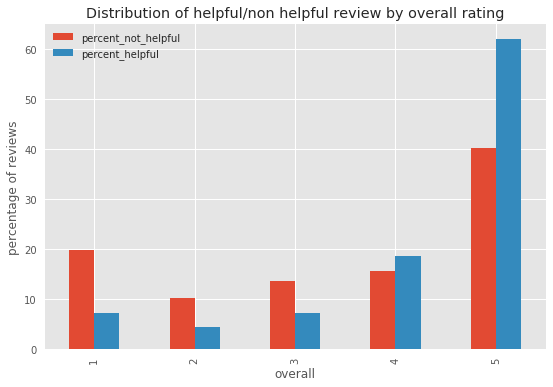

In [115]:
review_df4.plot(x='overall', y=['percent_not_helpful', 'percent_helpful'], kind='bar')
plt.title("Distribution of helpful/non helpful review by overall rating")
plt.ylabel('percentage of reviews')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


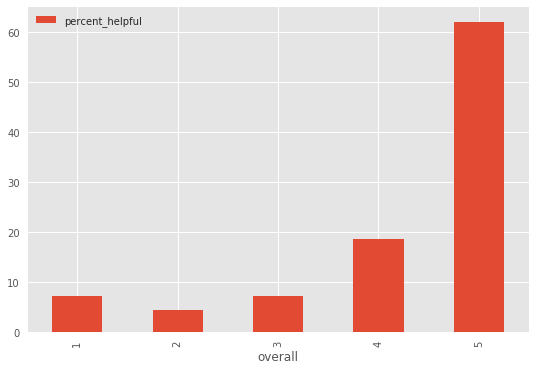

In [45]:
review_df4.plot(x='overall', y=['percent_helpful'], kind='bar');

So we can see from the 2 above plots
- As ratings become higher the number of helpful reviees increase. People are more likely to write helpful reviews for highly rated products.
- Higher rated reviews have higher proportion of helpful reviews

** How does word count relate to helpfulness? **

In [46]:
# Function to count number of words in each reviewText
def word_count(text):
    text = str(text)
    words = text.split(" ")
    word_count = len(words)
    return (word_count)

In [47]:
review_df1['word_count'] = pd.Series([word_count(x) for x in review_df1.reviewText], index=review_df1.index)
review_df1.head()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,timestamp,helpful_votes,overall_votes,percent_helpful,helpfulness_category,helpfulness_yn,word_count
4,B001CFRF7I,"[5, 5]",4,This heater works good. You have to have the ...,"01 23, 2013",A2O962SNGYQEK,BRYAN FISHER,it has it's place,1358899200,2013-01-23,5,5,100.00,greater_than_75%,helpful,46
14,B0082QJHLC,"[2, 2]",4,The comforter made my 11 year old son very hap...,"11 13, 2013",A28H7NL3KFIXIY,Melanie,Good Quality,1384300800,2013-11-13,2,2,100.00,greater_than_75%,helpful,37
15,B00CBI31SM,"[1, 5]",1,This is a really powerful substance for hair g...,"02 21, 2014",A1DJ38AMZ1BLRH,Abdullah,The side effects are nasty,1392940800,2014-02-21,1,5,20.00,less_than_25%,not_helpful,71
16,B008S1HUN8,"[4, 4]",5,I have pretty small wrist so most bracelets ar...,"12 30, 2012",A2SUH23TKGA782,~*Sheild Maiden*~,In one word.....awesome!,1356825600,2012-12-30,4,4,100.00,greater_than_75%,helpful,105
19,0446609234,"[5, 5]",5,A delightful picaresque adventure in the style...,"03 1, 2001",A279VCEMW3QNAN,Mike Berro,Fantasy in the Jack Vance style,983404800,2001-03-01,5,5,100.00,greater_than_75%,helpful,95


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


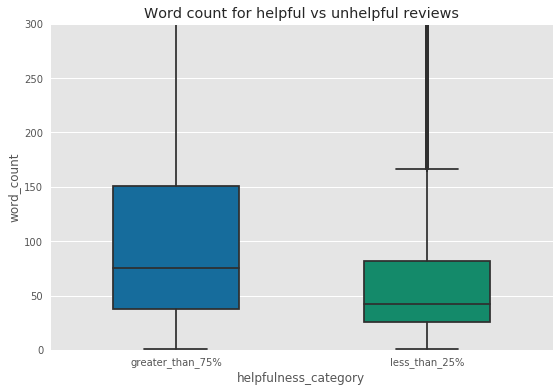

In [48]:
sns.boxplot(y='word_count', x='helpfulness_category', data=review_df1, width=0.5, palette="colorblind")
plt.title("Word count for helpful vs unhelpful reviews")
plt.ylim(0, 300);

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


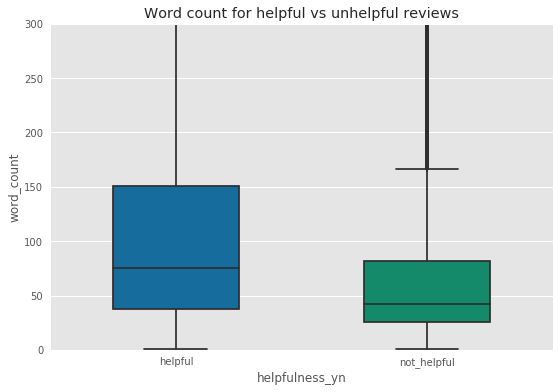

In [49]:
sns.boxplot(y='word_count', x='helpfulness_yn', data=review_df1, width=0.5, palette="colorblind")
plt.title("Word count for helpful vs unhelpful reviews")
plt.ylim(0, 300);

Its clear from the above plot that helpful reviews are longer, i.e. have higher word count.

### 3. Is there a relation between price and reviews

(i) In order to study price let's use the merged datafarme, i.e. product_df. First we'll look at how price is distributed across different products.

In [50]:
product_df.head(2)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,timestamp,categories,price,bought_together
0,B00691AF68,"[0, 0]",3,"I bought this case for the kickstand alone, si...","06 26, 2012",A2OTZJKZBLTRAQ,Randy,"4 stars for sturdiness, NO STARS FOR THE KICKS...",1340668800,2012-06-26,"[Cell Phones & Accessories, Cases, Basic Cases]",35.99,"[B006JHU3DC, B0064R6VWO]"
1,B004XCLYSS,"[0, 0]",5,Vintage style face gives an antique feel. Ban...,"02 9, 2013",A3QVJW34MZU61W,tjnks,Must have,1360368000,2013-02-09,"[Clothing, Shoes & Jewelry, Women]",80.00,


In [51]:
# Count number of products in dataset
product_df['asin'].nunique()

3127312

In [52]:
# Convert price to float
product_df['price'] = pd.to_numeric(product_df['price'], errors='coerce')
product_df['price'].describe()

count   7972768.00
mean         33.16
std          67.63
min           0.00
25%           7.10
50%          13.21
75%          29.95
max         999.99
Name: price, dtype: float64

Let's check for nulls

In [53]:
product_df['price'].isnull().sum()

2027232

There are a large number of null values. Let's drop them.

In [54]:
product_df = product_df.loc[~product_df.price.isnull(), :]

In [55]:
product_df.shape

(7972768, 13)

Let's plot the distribution of prices for all the categories. The 10M million reviews in the data set address.

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


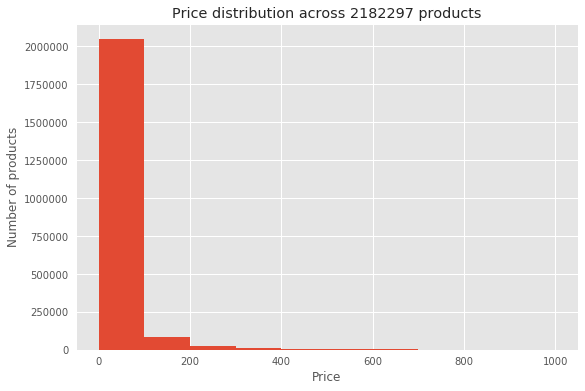

In [56]:
price_plot = product_df.loc[:, ['price', 'asin']].drop_duplicates().price.hist()
price_plot.set_title("Price distribution across 2182297 products")
price_plot.set_xlabel("Price")
price_plot.set_ylabel("Number of products");

Let's do the same thing as above but by dividing the price into categories

In [57]:
product_df['price_category'] = ''
product_df.price_category.loc[product_df.price.isnull()] = 'low_price'
product_df.price_category.loc[product_df.price <= 50] = 'low_price'
product_df.price_category.loc[(product_df.price <= 100) & (product_df.price > 50)] = 'mid_price'
product_df.price_category.loc[product_df.price > 100] = 'expensive'

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [58]:
product_df.sample(2)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,timestamp,categories,price,bought_together,price_category
4835750,B000PHMP9W,"[14, 17]",2,This one just doesn't do it. I've been paintin...,"06 6, 2012",A2KLYOF0NALY1M,slotcargene,Well - it ain't chrome!,1338940800,2012-06-06,"[Arts, Crafts & Sewing, Art Supplies, Painting]",5.36,[B003ZTNENS],low_price
1701700,B007HJ5RBY,"[1, 1]",5,It's hard to write a review about a hunk of sh...,"01 31, 2014",AU33OIUOWR2BV,"HeavyArms ""Jason""",It's effective,1391126400,2014-01-31,"[Electronics, Computers & Accessories, Cables ...",6.93,[B00E3W15P0],low_price


In [59]:
# Let's plot count of price categories
price_df = product_df.price_category.value_counts().reset_index()
price_df.rename(columns={'index': 'price_category', 'price_category': 'count'}, inplace=True)
price_df['percentage_of_reviews'] = price_df['count']*100.0/price_df['count'].sum()
price_df['price_category'] = price_df['price_category'].astype(str)

In [60]:
price_df

,price_category,count,percentage_of_reviews
0,low_price,6861826,86.07
1,mid_price,586253,7.35
2,expensive,524689,6.58


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


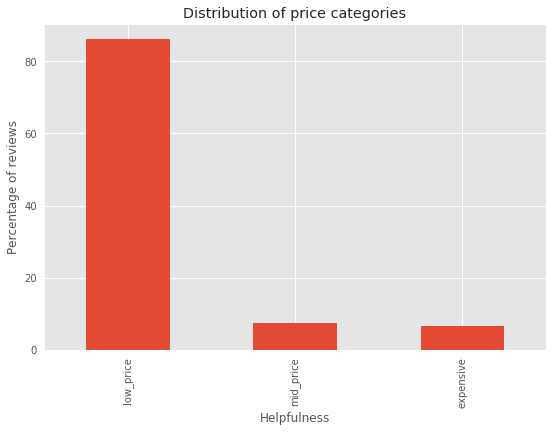

In [61]:
price_plot1 = price_df.plot(x='price_category', y='percentage_of_reviews', kind='bar')
price_plot1.set_title("Distribution of price categories")
price_plot1.set_xlabel("Helpfulness")
price_plot1.set_ylabel("Percentage of reviews")
price_plot1.legend_.remove()

Over 80% of Amazon products between 0 and 50, which makes sense as popular items at Amazon are not extremely expensive.

The next question to answer is how price affects ratings. Are more expensive products higly rated as compared to low priced products.

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


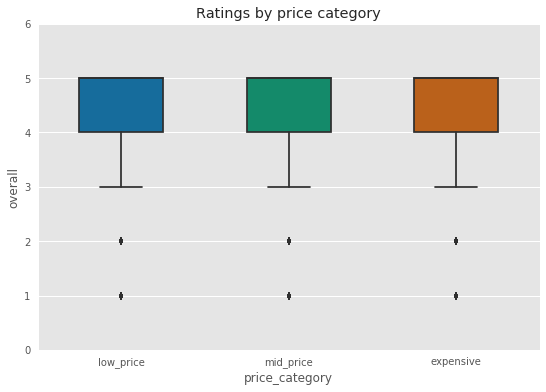

In [62]:
sns.boxplot(x='price_category', y='overall', data=product_df, width=0.5, palette="colorblind")
plt.ylim(0, 6)
plt.title("Ratings by price category")

In [63]:
product_df.overall.loc[product_df.price_category == 'low_price'].describe()

count   6861826.00
mean          4.18
std           1.24
min           1.00
25%           4.00
50%           5.00
75%           5.00
max           5.00
Name: overall, dtype: float64

In [64]:
product_df.overall.loc[product_df.price_category == 'mid_price'].describe()

count   586253.00
mean         4.12
std          1.31
min          1.00
25%          4.00
50%          5.00
75%          5.00
max          5.00
Name: overall, dtype: float64

In [65]:
product_df.overall.loc[product_df.price_category == 'expensive'].describe()

count   524689.00
mean         4.12
std          1.31
min          1.00
25%          4.00
50%          5.00
75%          5.00
max          5.00
Name: overall, dtype: float64

It seems that price does not actuall have any relation to reviews, which is quite surprising.

(iii) How does review length/word count affect price? Do higher priced products have longer reviews? 

In [66]:
product_df['word_count'] = product_df['reviewText'].apply(lambda x: word_count(x))
product_df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,timestamp,categories,price,bought_together,price_category,word_count
0,B00691AF68,"[0, 0]",3,"I bought this case for the kickstand alone, si...","06 26, 2012",A2OTZJKZBLTRAQ,Randy,"4 stars for sturdiness, NO STARS FOR THE KICKS...",1340668800,2012-06-26,"[Cell Phones & Accessories, Cases, Basic Cases]",35.99,"[B006JHU3DC, B0064R6VWO]",low_price,191
1,B004XCLYSS,"[0, 0]",5,Vintage style face gives an antique feel. Ban...,"02 9, 2013",A3QVJW34MZU61W,tjnks,Must have,1360368000,2013-02-09,"[Clothing, Shoes & Jewelry, Women]",80.00,,mid_price,21
2,0988703009,"[0, 0]",2,What disguises itself as a dystopian novel is ...,"07 10, 2014",A3IO3F5RJOPN6H,A.,Not what I expected,1404950400,2014-07-10,[Books],1.99,,low_price,183
3,0323004318,"[0, 0]",5,Great information that every nursing student s...,"01 15, 2013",A1Z7LRIQXKXQDC,E. Whisenhunt,Great Information,1358208000,2013-01-15,[Books],9.99,,low_price,30
4,B001CFRF7I,"[5, 5]",4,This heater works good. You have to have the ...,"01 23, 2013",A2O962SNGYQEK,BRYAN FISHER,it has it's place,1358899200,2013-01-23,"[Patio, Lawn & Garden, Outdoor Heaters & Acces...",62.99,[B000AMC5WO],mid_price,46


In [67]:
tmp = product_df.groupby('asin')['price', 'word_count'].mean()
tmp['price_category'] = ''
tmp.price_category.loc[tmp.price.isnull()] = 'low_price'
tmp.price_category.loc[tmp.price <= 50] = 'low_price'
tmp.price_category.loc[(tmp.price <= 100) & (tmp.price > 50)] = 'mid_price'
tmp.price_category.loc[tmp.price > 100] = 'expensive'
tmp.head(2)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,price,word_count,price_category
asin,,,
0000013714,8.09,30.00,low_price
0000031852,3.17,37.50,low_price


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


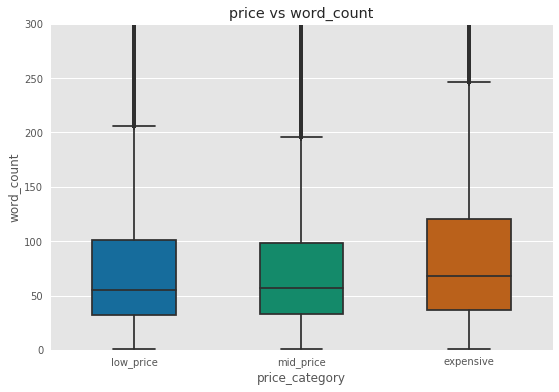

In [117]:
sns.boxplot(y='word_count', x='price_category', data=tmp, width=0.5, palette="colorblind")
plt.title("price vs word_count")
plt.ylim(0, 300);

From here we can see that more expensive products have slightly higher word count, which is expected. Reviewers are likely to take the time to write detailed reviews if they spend more money on the product.

### 5. Optional - Any other hypothesis you think is interesting, as long it would have business value for Amazon?

Using User IDs, one can recognize repeat reviewers. Reviewers that have reviewed over 50 products account for over 1% of all reviews in the database. We will call such/ reviewers frequent reviewers. (The cutoff choice of 50, as opposed to another choice, seemed to not have a larger impact on the results.) I asked: Does the behavior of frequent reviewers differ from that of infrequent reviewers?

In [69]:
# Count of number of reviews given by each reviewer
review_freq = review_df.groupby('reviewerID')['overall'].count().reset_index()
review_freq.head()

,reviewerID,overall
0,A000008615DZQRRI946FO,1
1,A000013090ZI3HIT9N5V,1
2,A0000488123JA1KQJTEM8,1
3,A00005181SC9PSCD58LCG,1
4,A000096625CHSNKYTYGZN,1


In [70]:
# If reviewer has >25 reviews thn label as frequent_reviewer or label as not_frequent_reviewer
review_freq.rename(columns={'overall':'review_count'}, inplace=True)
review_freq['reviewer_category'] = ''
review_freq.reviewer_category.loc[review_freq.review_count <= 50] = 'not_frequent_reviewer'
review_freq.reviewer_category.loc[review_freq.review_count > 50] = 'frequent_reviewer'

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [71]:
review_freq['reviewer_category'].value_counts()

not_frequent_reviewer    5795417
frequent_reviewer           3001
Name: reviewer_category, dtype: int64

Close to 1% of the reviewers are frequent reviewers

In [72]:
# Lets count the number of reviews by overall rating per reviewer
review_rating = review_df.groupby(['reviewerID', 'overall'])['asin'].count().reset_index()
review_rating.head()

,reviewerID,overall,asin
0,A000008615DZQRRI946FO,5,1
1,A000013090ZI3HIT9N5V,5,1
2,A0000488123JA1KQJTEM8,5,1
3,A00005181SC9PSCD58LCG,4,1
4,A000096625CHSNKYTYGZN,4,1


In [73]:
review_rating.rename(columns={'asin':'review_count_per_rating'}, inplace=True)
review_rating.head()

,reviewerID,overall,review_count_per_rating
0,A000008615DZQRRI946FO,5,1
1,A000013090ZI3HIT9N5V,5,1
2,A0000488123JA1KQJTEM8,5,1
3,A00005181SC9PSCD58LCG,4,1
4,A000096625CHSNKYTYGZN,4,1


In [74]:
review_freq_final = pd.merge(review_rating, review_freq, on=['reviewerID'])
review_freq_final.head()

,reviewerID,overall,review_count_per_rating,review_count,reviewer_category
0,A000008615DZQRRI946FO,5,1,1,not_frequent_reviewer
1,A000013090ZI3HIT9N5V,5,1,1,not_frequent_reviewer
2,A0000488123JA1KQJTEM8,5,1,1,not_frequent_reviewer
3,A00005181SC9PSCD58LCG,4,1,1,not_frequent_reviewer
4,A000096625CHSNKYTYGZN,4,1,1,not_frequent_reviewer


In [75]:
review_freq_final_agg = review_freq_final.groupby(['reviewer_category', 'overall'])['review_count_per_rating'].sum().reset_index()
review_freq_final_agg

,reviewer_category,overall,review_count_per_rating
0,frequent_reviewer,1,8041
1,frequent_reviewer,2,13609
2,frequent_reviewer,3,38173
3,frequent_reviewer,4,90421
4,frequent_reviewer,5,153088
5,not_frequent_reviewer,1,807112
6,not_frequent_reviewer,2,501827
7,not_frequent_reviewer,3,815195
8,not_frequent_reviewer,4,1781990
9,not_frequent_reviewer,5,5790544


In [108]:
#Let's look at reviews that are helpful by overall ratings
review_freq_final_agg1 = review_freq_final_agg[review_freq_final_agg['reviewer_category'] == 'frequent_reviewer']
review_freq_final_agg2 = review_freq_final_agg[review_freq_final_agg['reviewer_category'] == 'not_frequent_reviewer']
review_freq_final_agg1a = review_freq_final_agg1.groupby(['overall'])['review_count_per_rating'].sum().reset_index()
review_freq_final_agg1a['percent_frequent'] = review_freq_final_agg1a['review_count_per_rating']*100.0/review_freq_final_agg1a['review_count_per_rating'].sum()
review_freq_final_agg2a = review_freq_final_agg2.groupby(['overall'])['review_count_per_rating'].sum().reset_index()
review_freq_final_agg2a['percent_not_frequent'] = review_freq_final_agg2a['review_count_per_rating']*100.0/review_freq_final_agg2a['review_count_per_rating'].sum()

In [109]:
review_freq_final_agg1a.head()

,overall,review_count_per_rating,percent_frequent
0,1,8041,2.65
1,2,13609,4.49
2,3,38173,12.58
3,4,90421,29.81
4,5,153088,50.47


In [110]:
review_freq_final_agg2a.head()

,overall,review_count_per_rating,percent_not_frequent
0,1,807112,8.32
1,2,501827,5.18
2,3,815195,8.41
3,4,1781990,18.38
4,5,5790544,59.72


In [111]:
review_freq_final_agg3 = pd.merge(review_freq_final_agg1a, review_freq_final_agg2a, on=['overall'])
review_freq_final_agg3

,overall,review_count_per_rating_x,percent_frequent,review_count_per_rating_y,percent_not_frequent
0,1,8041,2.65,807112,8.32
1,2,13609,4.49,501827,5.18
2,3,38173,12.58,815195,8.41
3,4,90421,29.81,1781990,18.38
4,5,153088,50.47,5790544,59.72


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


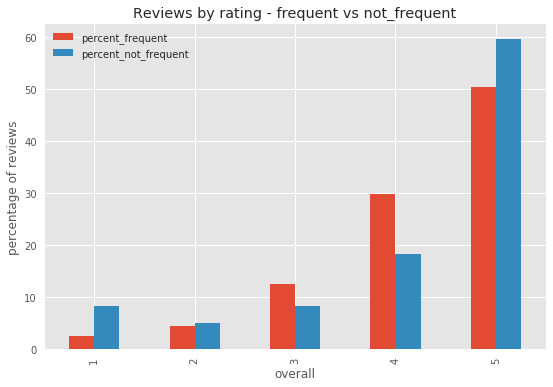

In [112]:
review_freq_final_agg3.plot(x='overall', y=['percent_frequent', 'percent_not_frequent'], kind='bar')
plt.title("Reviews by rating - frequent vs not_frequent")
plt.ylabel('percentage of reviews')

** (ii) Are frequent reviewers reviews more helpful? **

Do people vote more for reviews by frequent reviewers? Let's find out.

In [85]:
# Lets count the number of reviews by overall rating per reviewer
review_helpfulness = review_df.groupby(['reviewerID', 'helpfulness_category'])['asin'].count().reset_index()
review_helpfulness.head()

,reviewerID,helpfulness_category,asin
0,A000008615DZQRRI946FO,no_indication,1
1,A000013090ZI3HIT9N5V,no_indication,1
2,A0000488123JA1KQJTEM8,greater_than_75%,1
3,A00005181SC9PSCD58LCG,greater_than_75%,1
4,A000096625CHSNKYTYGZN,no_indication,1


In [83]:
review_df.columns

Index(['asin', 'helpful', 'overall', 'reviewText', 'reviewTime', 'reviewerID',
       'reviewerName', 'summary', 'unixReviewTime', 'timestamp',
       'helpful_votes', 'overall_votes', 'percent_helpful',
       'helpfulness_category'],
      dtype='object')

In [86]:
review_helpfulness.rename(columns={'asin':'review_count_per_helpfulness_category'}, inplace=True)
review_helpfulness.head()

,reviewerID,helpfulness_category,review_count_per_helpfulness_category
0,A000008615DZQRRI946FO,no_indication,1
1,A000013090ZI3HIT9N5V,no_indication,1
2,A0000488123JA1KQJTEM8,greater_than_75%,1
3,A00005181SC9PSCD58LCG,greater_than_75%,1
4,A000096625CHSNKYTYGZN,no_indication,1


In [90]:
review_helpfulness_final = pd.merge(review_freq, review_helpfulness, on=['reviewerID'])
review_helpfulness_final.head()

,reviewerID,review_count,reviewer_category,helpfulness_category,review_count_per_helpfulness_category
0,A000008615DZQRRI946FO,1,not_frequent_reviewer,no_indication,1
1,A000013090ZI3HIT9N5V,1,not_frequent_reviewer,no_indication,1
2,A0000488123JA1KQJTEM8,1,not_frequent_reviewer,greater_than_75%,1
3,A00005181SC9PSCD58LCG,1,not_frequent_reviewer,greater_than_75%,1
4,A000096625CHSNKYTYGZN,1,not_frequent_reviewer,no_indication,1


In [91]:
review_helpfulness_final_agg = review_helpfulness_final.groupby(['reviewer_category', 'helpfulness_category'])['review_count_per_helpfulness_category'].sum().reset_index()
review_helpfulness_final_agg

,reviewer_category,helpfulness_category,review_count_per_helpfulness_category
0,frequent_reviewer,25%_to_75%,52068
1,frequent_reviewer,greater_than_75%,141788
2,frequent_reviewer,less_than_25%,18562
3,frequent_reviewer,no_indication,90914
4,not_frequent_reviewer,25%_to_75%,973319
5,not_frequent_reviewer,greater_than_75%,2603986
6,not_frequent_reviewer,less_than_25%,720576
7,not_frequent_reviewer,no_indication,5398787


In [96]:
#Let's look at reviews that are helpful by helpfulness vategory
review_helpfulness_final_agg1 = review_helpfulness_final_agg[review_helpfulness_final_agg['reviewer_category'] == 'frequent_reviewer']
review_helpfulness_final_agg2 = review_helpfulness_final_agg[review_helpfulness_final_agg['reviewer_category'] == 'not_frequent_reviewer']
review_helpfulness_final_agg1a = review_helpfulness_final_agg1.groupby(['helpfulness_category'])['review_count_per_helpfulness_category'].sum().reset_index()
review_helpfulness_final_agg1a['percent_frequent'] = review_helpfulness_final_agg1a['review_count_per_helpfulness_category']*100.0/review_helpfulness_final_agg1a['review_count_per_helpfulness_category'].sum()
review_helpfulness_final_agg2a = review_helpfulness_final_agg2.groupby(['helpfulness_category'])['review_count_per_helpfulness_category'].sum().reset_index()
review_helpfulness_final_agg2a['percent_not_frequent'] = review_helpfulness_final_agg2a['review_count_per_helpfulness_category']*100.0/review_helpfulness_final_agg2a['review_count_per_helpfulness_category'].sum()

In [98]:
review_helpfulness_final_agg1a

,helpfulness_category,review_count_per_helpfulness_category,percent_frequent
0,25%_to_75%,52068,17.17
1,greater_than_75%,141788,46.74
2,less_than_25%,18562,6.12
3,no_indication,90914,29.97


In [100]:
review_helpfulness_final_agg2a

,helpfulness_category,review_count_per_helpfulness_category,percent_not_frequent
0,25%_to_75%,973319,10.04
1,greater_than_75%,2603986,26.85
2,less_than_25%,720576,7.43
3,no_indication,5398787,55.68


In [102]:
review_helpfulness_final_agg3 = pd.merge(review_helpfulness_final_agg1a, review_helpfulness_final_agg2a, on=['helpfulness_category'])
review_helpfulness_final_agg3

,helpfulness_category,review_count_per_helpfulness_category_x,percent_frequent,review_count_per_helpfulness_category_y,percent_not_frequent
0,25%_to_75%,52068,17.17,973319,10.04
1,greater_than_75%,141788,46.74,2603986,26.85
2,less_than_25%,18562,6.12,720576,7.43
3,no_indication,90914,29.97,5398787,55.68


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


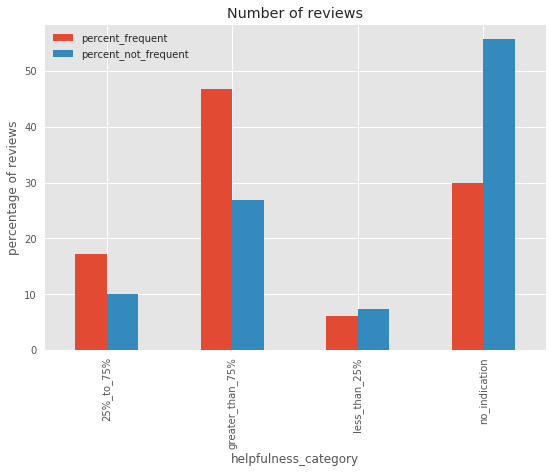

In [103]:
review_helpfulness_final_agg3.plot(x='helpfulness_category', y=['percent_frequent', 'percent_not_frequent'], kind='bar')
plt.title("Number of reviews")
plt.ylabel('percentage of reviews')